# Modelo multinput

## Modelamiento 

Como primer paso vamos a importar las bibliotecas necesarias

In [1]:
from sklearn.preprocessing import LabelBinarizer,MinMaxScaler,LabelEncoder,OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.layers import concatenate
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import datetime
import pandas as pd
import numpy as np
import argparse
import locale
import glob
import cv2
import os


Nuestro propósito es **corroborar (o descartar) que agregar las fotos de los choques de autos asegurados permite una estimación más exacta de los montos, respecto del caso base que sólo usa información tabular**.
Para ello haremos uso de una red neuronal _multi input_.

Ya se hizo un trabajo detallado de exploración de los datos, el que se puede encontrar [acá](https://github.com/fedeos/Tesis-UAI/blob/master/EDA%20Tesis%20MIA.ipynb).

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
0,img_4511041.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
1,img_4511041_180.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
2,img_4511041_270.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
3,img_4511041_90.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
4,img_4511208.jpg,A,32700.0,817.5,2026-05-30,28486.68,0,0.0


Nuestro propósito es contar con un modelo de regresión que relacione el daño (```Amount```) con el resto de las variables:
- Modelo 1: Usando solo fotografías
- Modelo 2: Usando fotografías y además las variables númericas y categóricas

In [4]:
df.dtypes

Image_path            object
Insurance_company     object
Cost_of_vehicle      float64
Min_coverage         float64
Expiry_date           object
Max_coverage         float64
Condition              int64
Amount               float64
dtype: object

In [5]:
df.describe()

,Cost_of_vehicle,Min_coverage,Max_coverage,Condition,Amount
count,1601.000000,1601.000000,1601.000000,1696.000000,1685.000000
mean,37790.318551,944.757964,15421.337189,0.766509,3391.451632
std,8944.723303,223.618083,11468.101665,0.423176,3262.359910
min,11100.000000,277.500000,2853.000000,0.000000,-999.000000
25%,30100.000000,752.500000,7953.000000,1.000000,325.000000
50%,37900.000000,947.500000,10578.000000,1.000000,3363.000000
75%,45400.000000,1135.000000,13403.000000,1.000000,5599.000000
max,53500.000000,1337.500000,46495.680000,1.000000,59844.000000


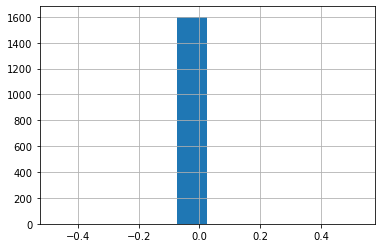

In [6]:
(df['Min_coverage']/df['Cost_of_vehicle']).hist();

In [7]:
df['Insurance_company'].value_counts()

B     172
BQ    167
A     165
AA    159
C     155
BB    154
O     153
DA    152
BC    151
AC    137
RE    131
Name: Insurance_company, dtype: int64

Se debe hacer notar que:
- La cobertura mínima es sistemáticamente el 25% del valor del automóvil, de modo que la variable no aporta información
- Creemos Sería razonable suponer que tanto la máxima cobertura (```Max_coverage```)  como el monto del daño (```Amount```) sean expresados como proporción del costo del vehículo
- Expresaremos ```Expiry_date```como días pendientes de cobertura a partir de una fecha nominal
- Notar que las compañías de seguros son 11 distintas

In [8]:
HOY = pd.to_datetime(datetime.date(2021,6,30)) # Fecha nominal para calcular los días de cobertura pendiente

In [9]:
df.head()

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
0,img_4511041.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
1,img_4511041_180.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
2,img_4511041_270.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
3,img_4511041_90.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
4,img_4511208.jpg,A,32700.0,817.5,2026-05-30,28486.68,0,0.0


Generaremos una función ad hoc para contar con conjuntos de entrenamiento y evaluación.  El conjunto de prueba con que contamops no está etiquetado.
Los comentarios pertinentes se agregan en el código de la función.

In [10]:
def preprocesa_atributos(input_path):
    
    '''
    Dada la ruta a un archivo devuelve partición en conjuntos de entrenamiento y validación
    
    input: ruta a un archivo, el que debe contener en una el link a la foto.
    output: Conjuntos de entrenamiento y Validación, además de pd.Series con ruta a las imágenes
    
    
    '''
    
    df=pd.read_csv(input_path)
    df.dropna(inplace=True)
    df = df.drop(columns=['Condition']) # Queremos predecir el monto, por el momento no nos interesa
    df = df[(df['Amount']<=df['Cost_of_vehicle'])] #Filtramos casos: Monto del daño no debiera ser > valor auto
    df = df[df['Amount']>0] #Elimino vehículos sin daño
    
    df['Expiry_date']=pd.to_datetime(df['Expiry_date'])
    df['dias_pendientes_cobertura']=(df['Expiry_date']-HOY).dt.days.astype(int) #Permite contar días hasta fin cobertura
    df['relative_amount'] = df['Amount']/df['Cost_of_vehicle'] #Se expresa en términos relativos
    df['relative_max_cov'] = df['Max_coverage']/df['Cost_of_vehicle'] #Se expresa en términos relativos
    
    
    df = df.drop(columns=['Min_coverage','Expiry_date','Max_coverage','Amount'])
    
    scaler = MinMaxScaler() #Vamos a escalar variables numéricas
     
    
    X = df.drop(columns=['relative_amount'])
    y = df['relative_amount']
    
    X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.2, random_state=123)
    
    
    X_train_num = X_train[['Cost_of_vehicle','dias_pendientes_cobertura']]
    X_val_num = X_val[['Cost_of_vehicle','dias_pendientes_cobertura']]
    
    X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), 
                                      columns=X_train_num.columns,
                                      index=X_train.index)
    
    X_val_num_scaled = pd.DataFrame(scaler.transform(X_val_num), 
                                      columns=X_val_num.columns,
                                       index=X_val.index)
    
    lb = LabelBinarizer()# Codificaremos valores categóricos
    
    
    X_train_encoded = pd.DataFrame(lb.fit_transform(X_train['Insurance_company']),
                                    columns=lb.classes_,
                                   index=X_train.index)
    
    X_val_encoded = pd.DataFrame(lb.transform(X_val['Insurance_company']),
                                    columns=lb.classes_,
                                   index=X_val.index)
    
    
    X_train_feat = pd.concat([X_train['relative_max_cov'],X_train_num_scaled,X_train_encoded],axis=1)
    X_val_feat = pd.concat([X_val['relative_max_cov'],X_val_num_scaled,X_val_encoded],axis=1)
    
    X_train_im = X_train['Image_path']
    X_val_im = X_val['Image_path']
    
    
    return X_train_feat,X_train_im, X_val_feat,X_val_im,y_train,y_val
    

In [11]:
X_train_feat,X_train_im, X_val_feat,X_val_im,y_train,y_val = preprocesa_atributos('train.csv')

Dejo esta parte por si quisiera inspeccionar imágenes

In [12]:
'''
i=1 

for indice in X_train_im.index:

    img = cv2.imread('trainImages/'+X_train_im[indice])
    trans_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(trans_img)
    plt.title('foto '+str(i)+':'+str(y_train[indice]))
    plt.show()
    i+=1
'''

"\ni=1 \n\nfor indice in X_train_im.index:\n\n    img = cv2.imread('trainImages/'+X_train_im[indice])\n    trans_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n\n    plt.imshow(trans_img)\n    plt.title('foto '+str(i)+':'+str(y_train[indice]))\n    plt.show()\n    i+=1\n"

Debemos cargar las imágenes, como arreglos de numpy.

In [13]:
def carga_imagenes(serie_fotos, inputPath):
    
    nuevas_imagenes = []
    for foto in serie_fotos:
        imagen = cv2.imread(inputPath+'/'+foto)
        imagen = cv2.resize(imagen, (64, 64)) #Dejo todas las fotos en 64 x 64
        nuevas_imagenes.append(imagen)
    return np.array(nuevas_imagenes)/255.0 # Normalizo a factor de 1

Vamos a crear cada modelo por separado

Creamos un generador para modelos que solo usen datos tabulares

In [14]:
def create_mlp(dim, regress=True):
    # Perceptron multicapas muy simple para Redes neuronales
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(1, activation="relu"))

    # ¿Hay nodo de regresión?
    if regress:
        model.add(Dense(1, activation="linear"))

    # Devuelve un modelo
    return model

Creamos un generador para modelos que solo use imágenes

In [15]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=True):
# Ojo: hay que cambiar orden de las dimensiones

    inputShape = (height, width, depth)
    chanDim = -1

    # Definir input del modelos
    inputs = Input(shape=inputShape)

    # Loop para cada uno de los filtros
    for (i, f) in enumerate(filters):
    # Ojo con capas de convolución
        if i == 0:
            x = inputs

    # CONV => RELU => BN => POOL
    x = Conv2D(f, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Aplanar nuevamente, luego FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(32)(x)
    x = Dense(8)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # Aplicar al final
    x = Dense(1)(x)
    x = Activation("relu")(x)

    # ¿Hay nodo de regresión?
    if regress:
        x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

In [16]:
imagenes_train = carga_imagenes(X_train_im,'trainResizedImages')
imagenes_val = carga_imagenes(X_val_im,'trainResizedImages')

## Entrenamiento de modelos

Primero voy a entrenar el modelo que solamente contiene imágenes

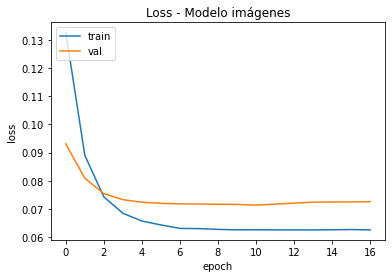

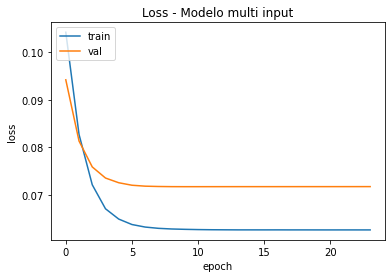

El error absoluto promedio del modelo que solo usa imágenes es 0.0726.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 1 finalizada


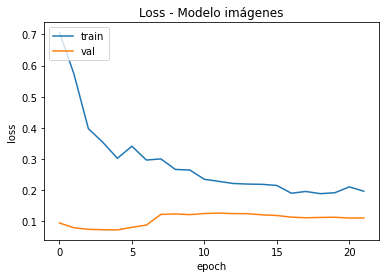

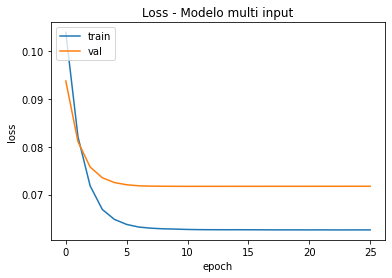

El error absoluto promedio del modelo que solo usa imágenes es 0.1109.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 2 finalizada


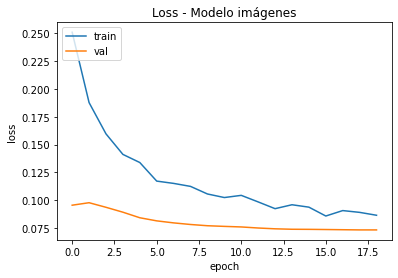

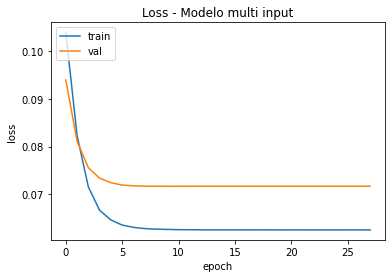

El error absoluto promedio del modelo que solo usa imágenes es 0.0736.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 3 finalizada


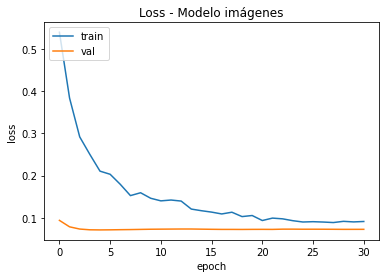

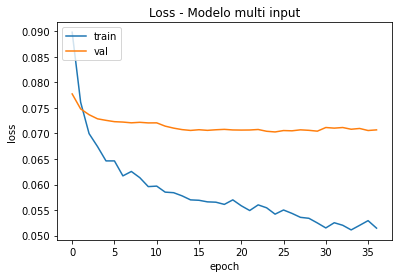

El error absoluto promedio del modelo que solo usa imágenes es 0.0731.
    A su vez, el error absoluto promedio del modelo multi input es 0.0707.
Iteración 4 finalizada


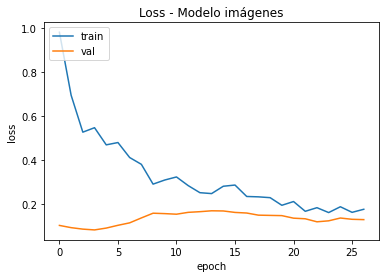

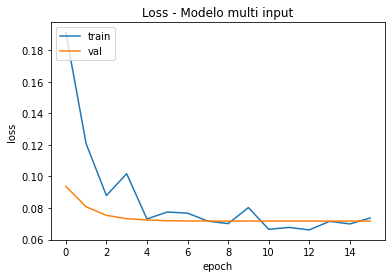

El error absoluto promedio del modelo que solo usa imágenes es 0.1301.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 5 finalizada


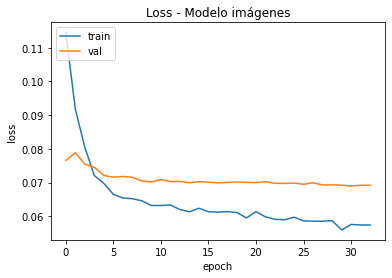

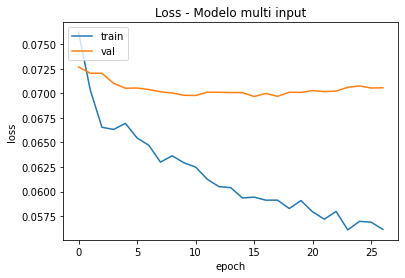

El error absoluto promedio del modelo que solo usa imágenes es 0.0692.
    A su vez, el error absoluto promedio del modelo multi input es 0.0706.
Iteración 6 finalizada


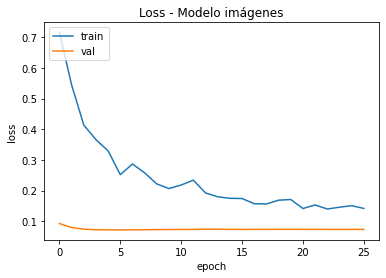

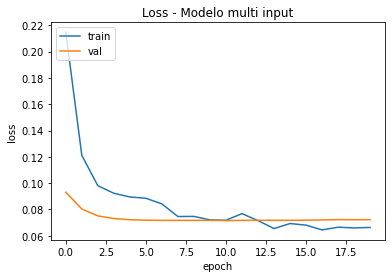

El error absoluto promedio del modelo que solo usa imágenes es 0.0735.
    A su vez, el error absoluto promedio del modelo multi input es 0.0722.
Iteración 7 finalizada


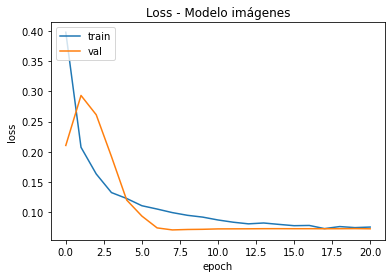

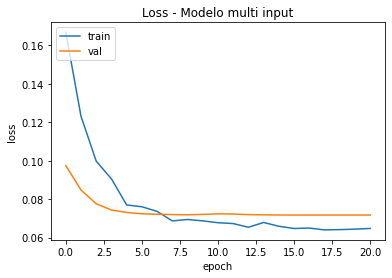

El error absoluto promedio del modelo que solo usa imágenes es 0.0722.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 8 finalizada


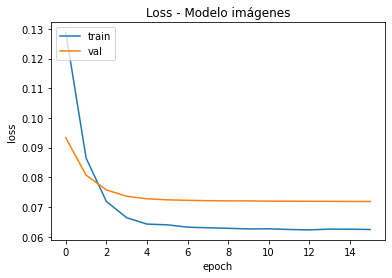

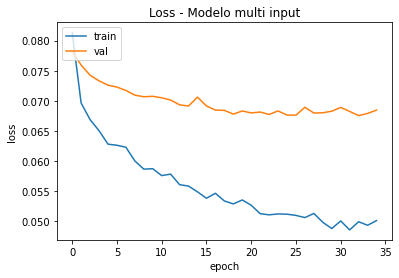

El error absoluto promedio del modelo que solo usa imágenes es 0.0719.
    A su vez, el error absoluto promedio del modelo multi input es 0.0684.
Iteración 9 finalizada


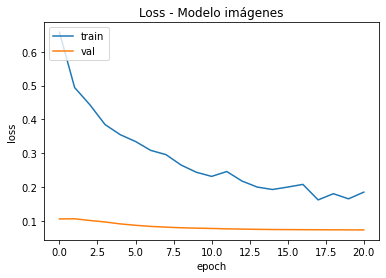

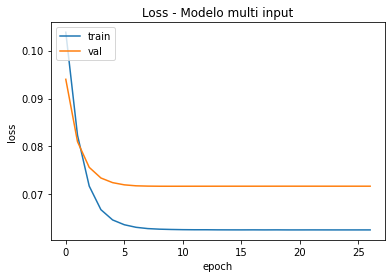

El error absoluto promedio del modelo que solo usa imágenes es 0.0734.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 10 finalizada


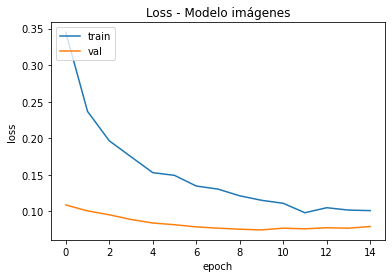

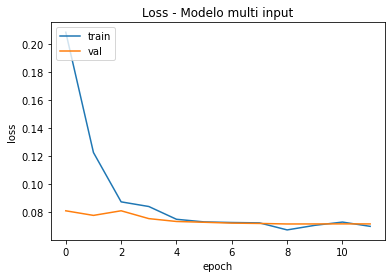

El error absoluto promedio del modelo que solo usa imágenes es 0.0793.
    A su vez, el error absoluto promedio del modelo multi input es 0.0718.
Iteración 11 finalizada


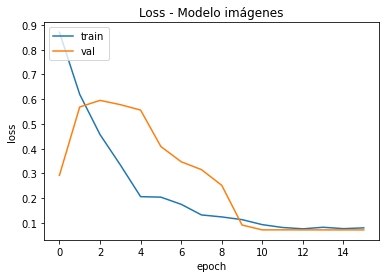

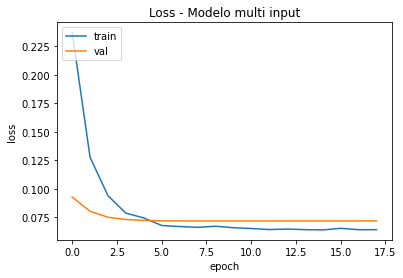

El error absoluto promedio del modelo que solo usa imágenes es 0.0721.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 12 finalizada


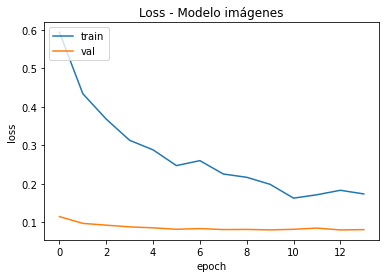

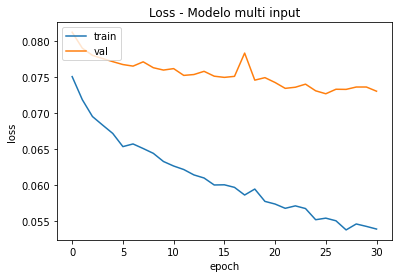

El error absoluto promedio del modelo que solo usa imágenes es 0.0813.
    A su vez, el error absoluto promedio del modelo multi input es 0.0731.
Iteración 13 finalizada


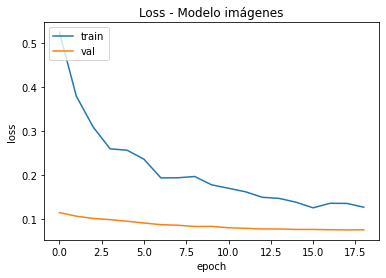

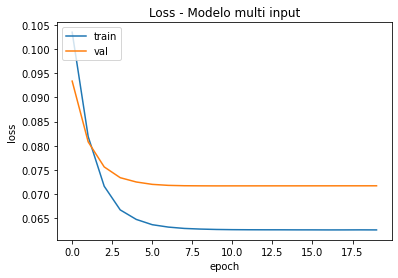

El error absoluto promedio del modelo que solo usa imágenes es 0.075.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 14 finalizada


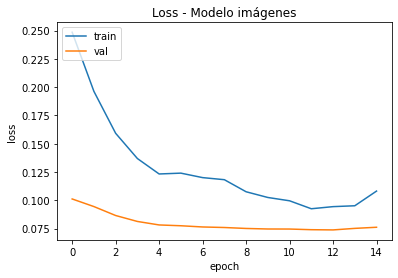

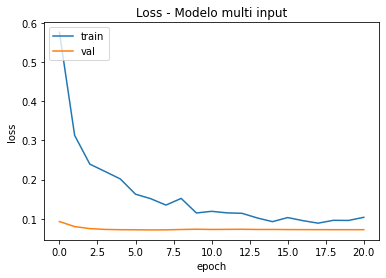

El error absoluto promedio del modelo que solo usa imágenes es 0.0762.
    A su vez, el error absoluto promedio del modelo multi input es 0.0719.
Iteración 15 finalizada


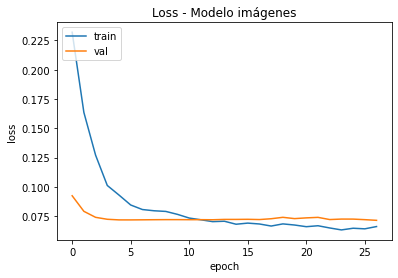

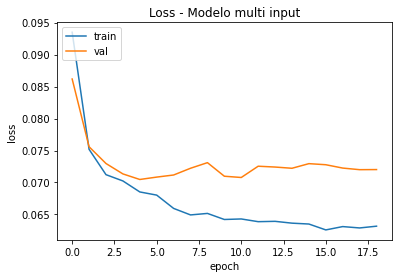

El error absoluto promedio del modelo que solo usa imágenes es 0.0714.
    A su vez, el error absoluto promedio del modelo multi input es 0.072.
Iteración 16 finalizada


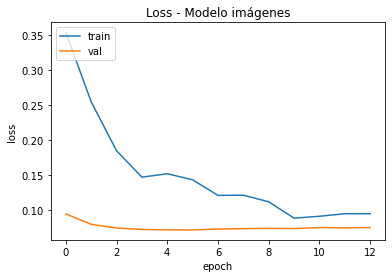

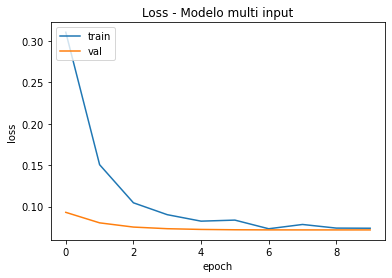

El error absoluto promedio del modelo que solo usa imágenes es 0.0748.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 17 finalizada


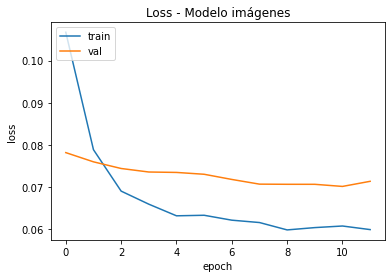

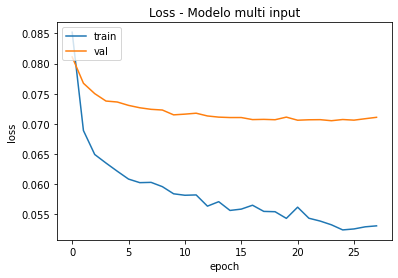

El error absoluto promedio del modelo que solo usa imágenes es 0.0713.
    A su vez, el error absoluto promedio del modelo multi input es 0.0711.
Iteración 18 finalizada


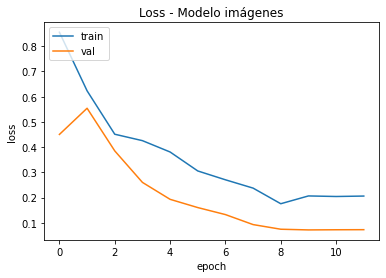

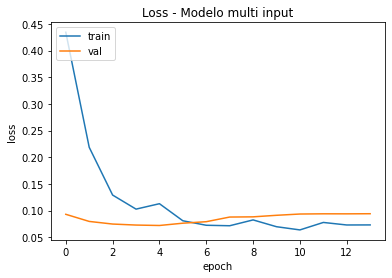

El error absoluto promedio del modelo que solo usa imágenes es 0.073.
    A su vez, el error absoluto promedio del modelo multi input es 0.0942.
Iteración 19 finalizada


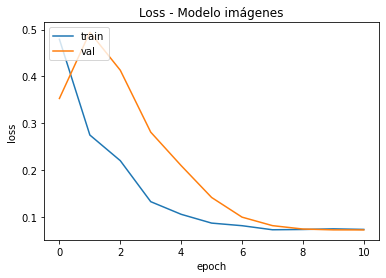

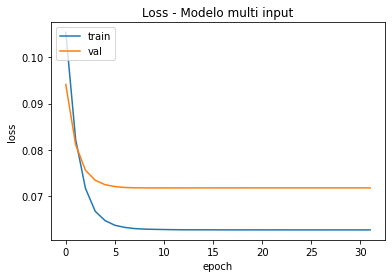

El error absoluto promedio del modelo que solo usa imágenes es 0.072.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 20 finalizada


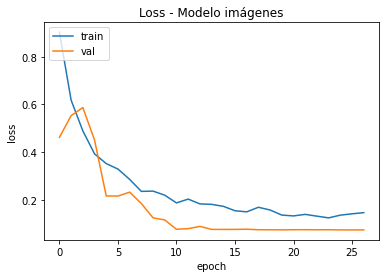

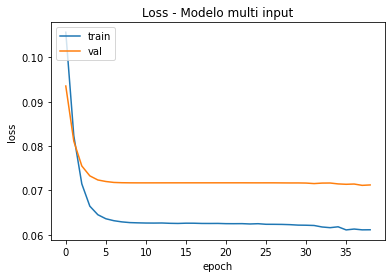

El error absoluto promedio del modelo que solo usa imágenes es 0.0737.
    A su vez, el error absoluto promedio del modelo multi input es 0.0712.
Iteración 21 finalizada


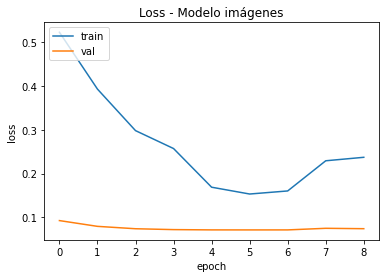

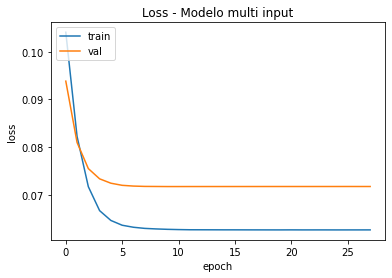

El error absoluto promedio del modelo que solo usa imágenes es 0.0745.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 22 finalizada


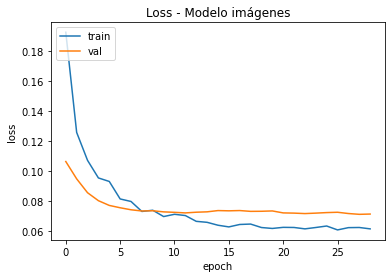

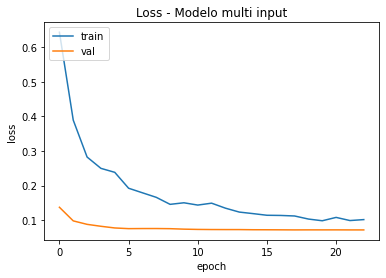

El error absoluto promedio del modelo que solo usa imágenes es 0.0712.
    A su vez, el error absoluto promedio del modelo multi input es 0.0719.
Iteración 23 finalizada


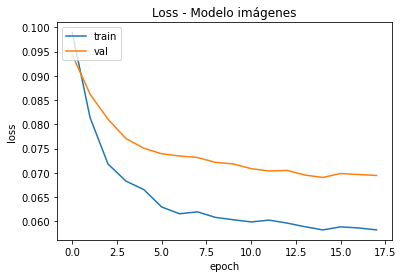

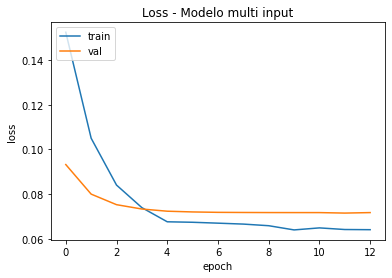

El error absoluto promedio del modelo que solo usa imágenes es 0.0695.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 24 finalizada


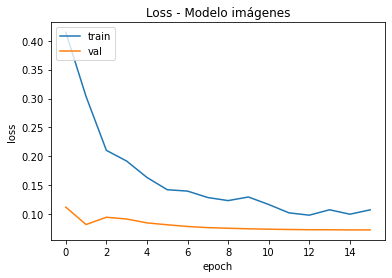

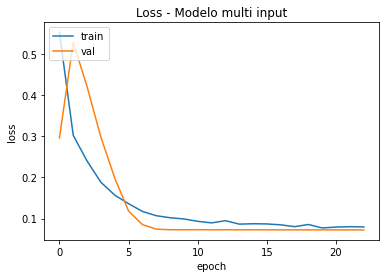

El error absoluto promedio del modelo que solo usa imágenes es 0.0731.
    A su vez, el error absoluto promedio del modelo multi input es 0.0722.
Iteración 25 finalizada


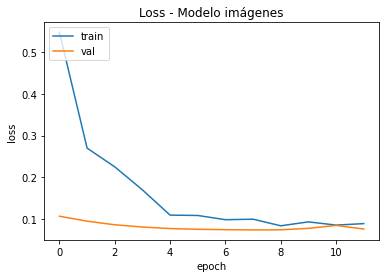

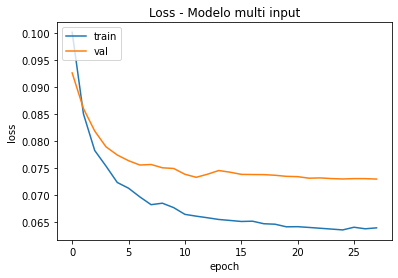

El error absoluto promedio del modelo que solo usa imágenes es 0.0753.
    A su vez, el error absoluto promedio del modelo multi input es 0.0729.
Iteración 26 finalizada


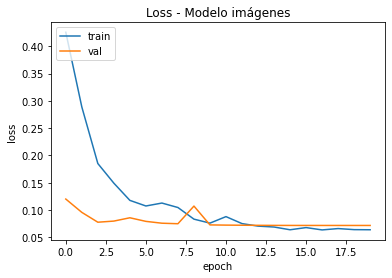

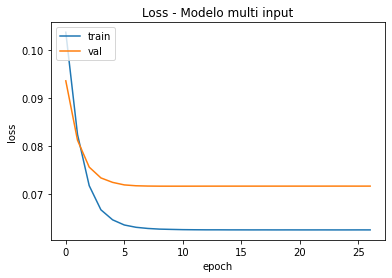

El error absoluto promedio del modelo que solo usa imágenes es 0.0717.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 27 finalizada


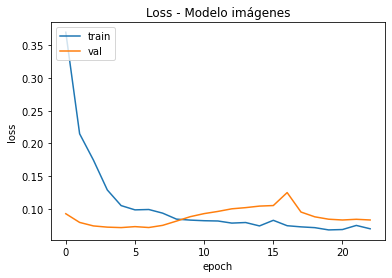

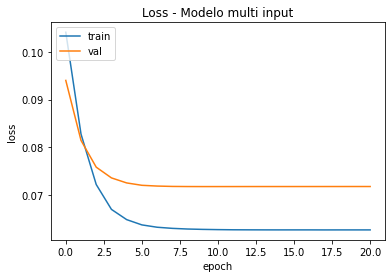

El error absoluto promedio del modelo que solo usa imágenes es 0.0834.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 28 finalizada


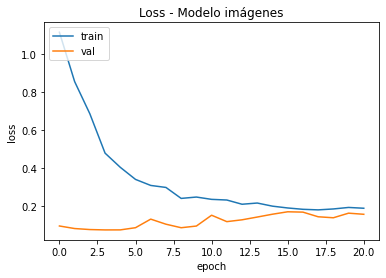

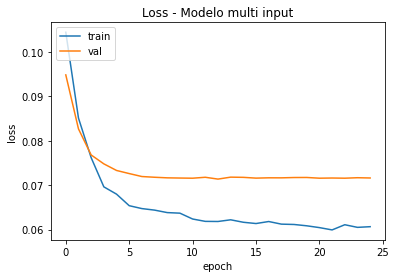

El error absoluto promedio del modelo que solo usa imágenes es 0.1549.
    A su vez, el error absoluto promedio del modelo multi input es 0.0716.
Iteración 29 finalizada


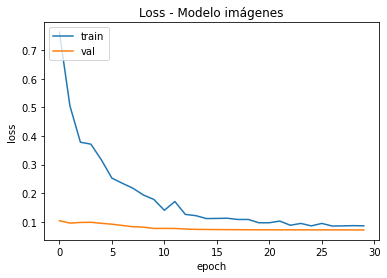

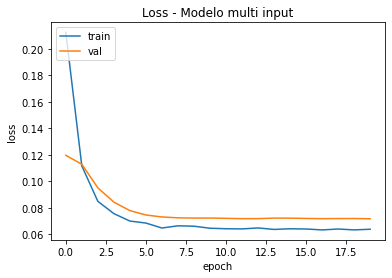

El error absoluto promedio del modelo que solo usa imágenes es 0.0718.
    A su vez, el error absoluto promedio del modelo multi input es 0.0718.
Iteración 30 finalizada


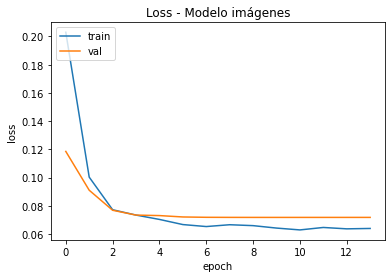

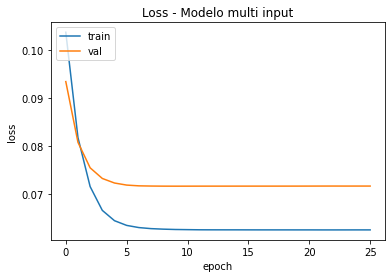

El error absoluto promedio del modelo que solo usa imágenes es 0.0717.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 31 finalizada


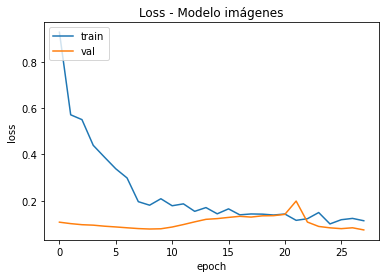

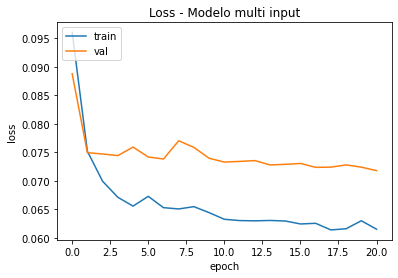

El error absoluto promedio del modelo que solo usa imágenes es 0.0735.
    A su vez, el error absoluto promedio del modelo multi input es 0.0718.
Iteración 32 finalizada


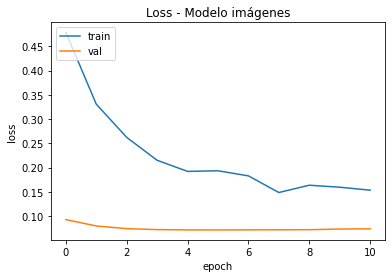

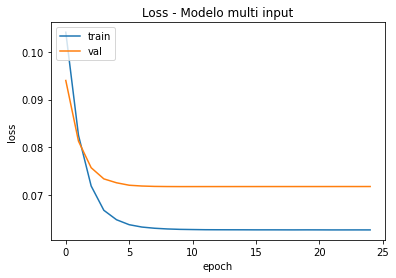

El error absoluto promedio del modelo que solo usa imágenes es 0.074.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 33 finalizada


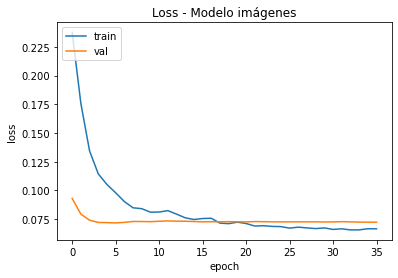

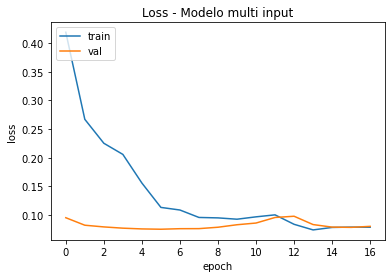

El error absoluto promedio del modelo que solo usa imágenes es 0.0724.
    A su vez, el error absoluto promedio del modelo multi input es 0.0803.
Iteración 34 finalizada


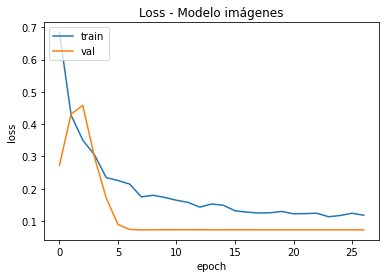

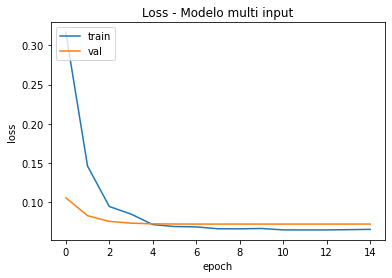

El error absoluto promedio del modelo que solo usa imágenes es 0.073.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 35 finalizada


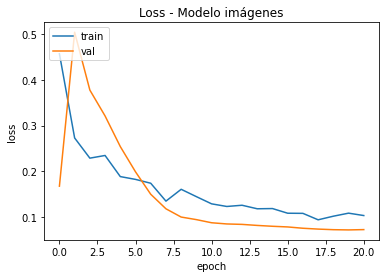

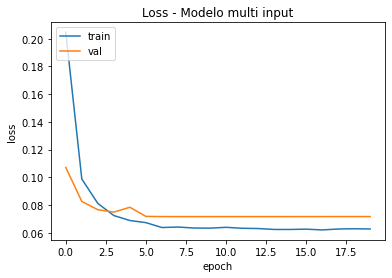

El error absoluto promedio del modelo que solo usa imágenes es 0.0727.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 36 finalizada


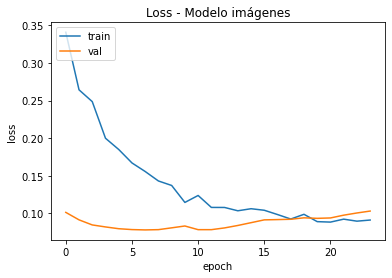

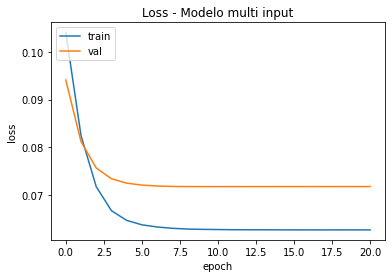

El error absoluto promedio del modelo que solo usa imágenes es 0.1032.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 37 finalizada


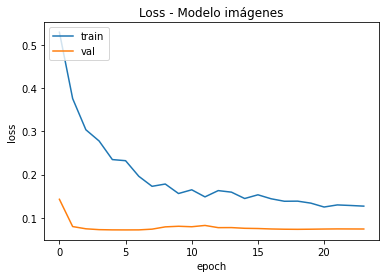

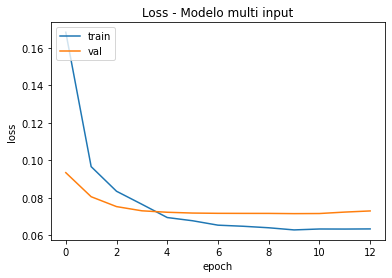

El error absoluto promedio del modelo que solo usa imágenes es 0.0737.
    A su vez, el error absoluto promedio del modelo multi input es 0.073.
Iteración 38 finalizada


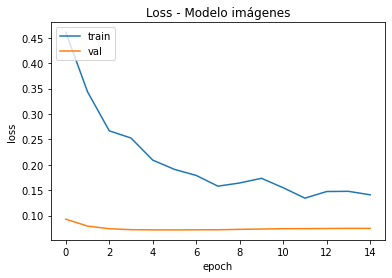

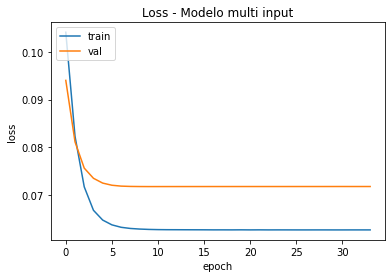

El error absoluto promedio del modelo que solo usa imágenes es 0.0747.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 39 finalizada


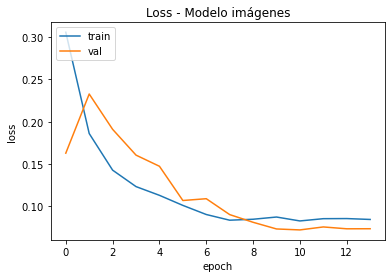

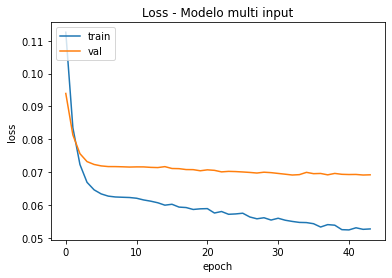

El error absoluto promedio del modelo que solo usa imágenes es 0.0736.
    A su vez, el error absoluto promedio del modelo multi input es 0.0692.
Iteración 40 finalizada


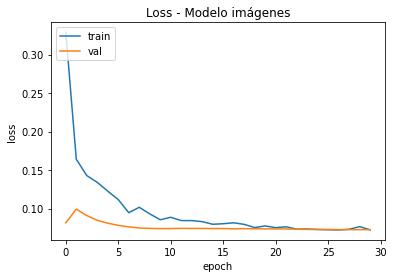

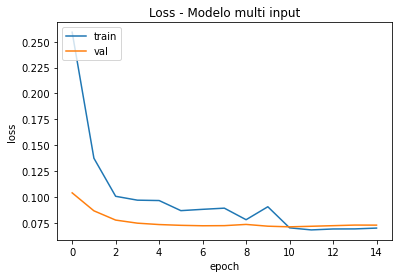

El error absoluto promedio del modelo que solo usa imágenes es 0.0728.
    A su vez, el error absoluto promedio del modelo multi input es 0.0727.
Iteración 41 finalizada


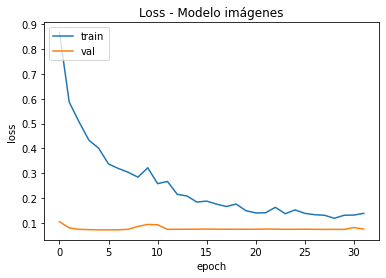

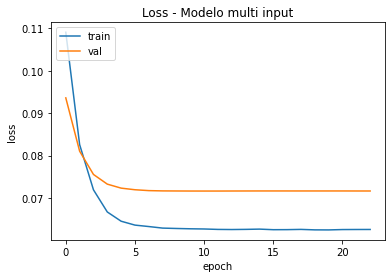

El error absoluto promedio del modelo que solo usa imágenes es 0.0748.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 42 finalizada


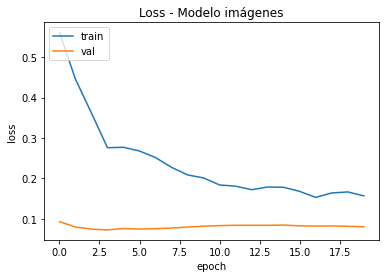

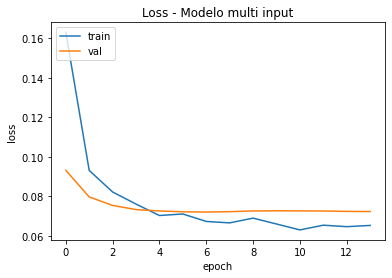

El error absoluto promedio del modelo que solo usa imágenes es 0.0801.
    A su vez, el error absoluto promedio del modelo multi input es 0.0722.
Iteración 43 finalizada


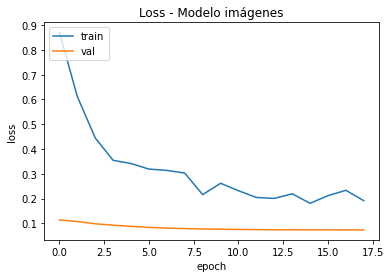

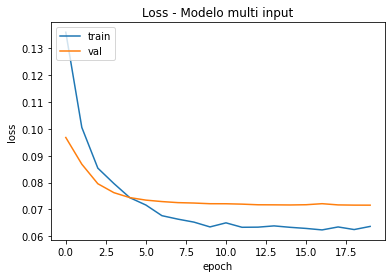

El error absoluto promedio del modelo que solo usa imágenes es 0.0736.
    A su vez, el error absoluto promedio del modelo multi input es 0.0716.
Iteración 44 finalizada


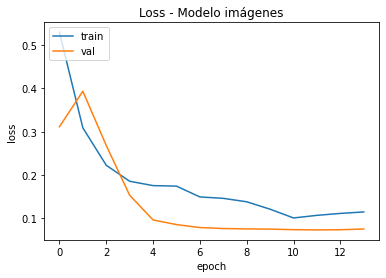

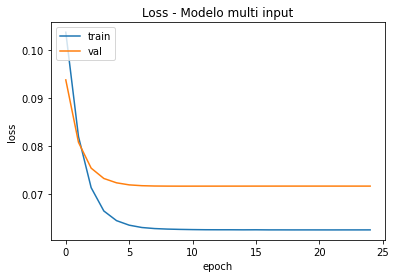

El error absoluto promedio del modelo que solo usa imágenes es 0.0752.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 45 finalizada


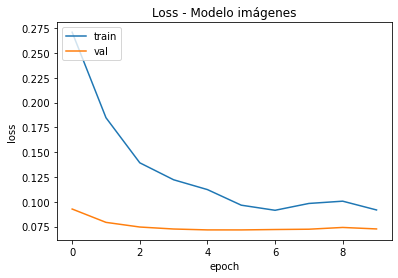

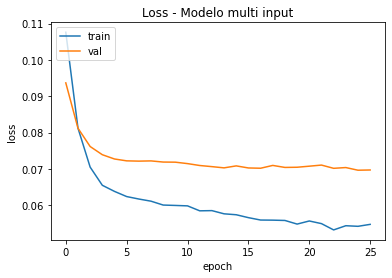

El error absoluto promedio del modelo que solo usa imágenes es 0.0726.
    A su vez, el error absoluto promedio del modelo multi input es 0.0697.
Iteración 46 finalizada


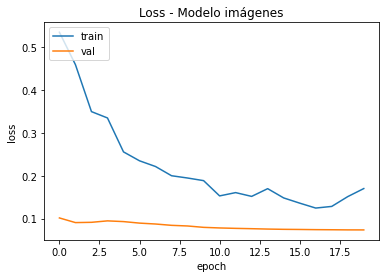

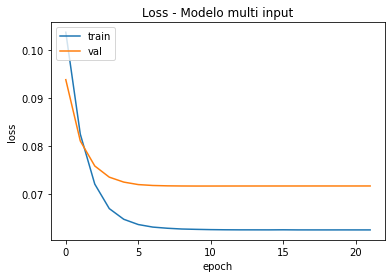

El error absoluto promedio del modelo que solo usa imágenes es 0.0734.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 47 finalizada


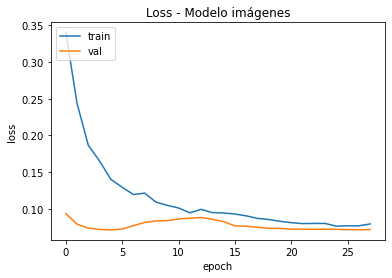

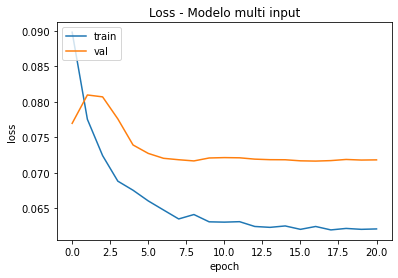

El error absoluto promedio del modelo que solo usa imágenes es 0.0722.
    A su vez, el error absoluto promedio del modelo multi input es 0.0718.
Iteración 48 finalizada


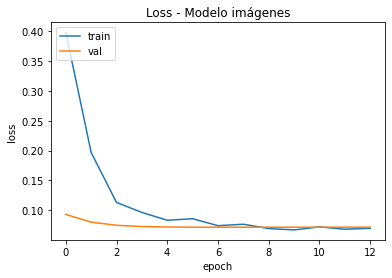

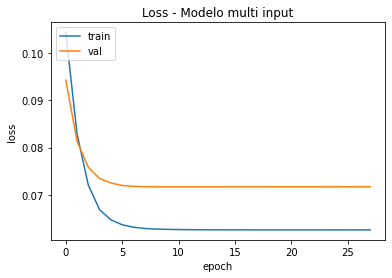

El error absoluto promedio del modelo que solo usa imágenes es 0.0718.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 49 finalizada


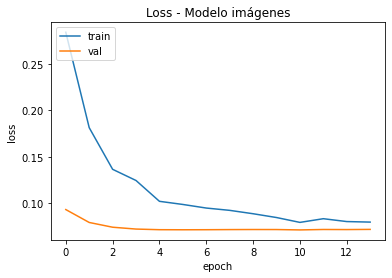

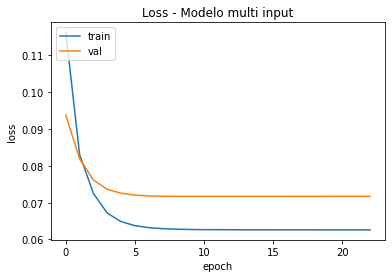

El error absoluto promedio del modelo que solo usa imágenes es 0.0721.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 50 finalizada


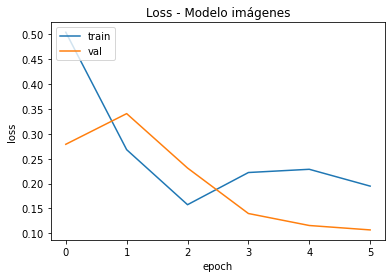

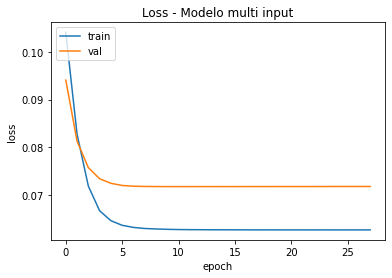

El error absoluto promedio del modelo que solo usa imágenes es 0.1066.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 51 finalizada


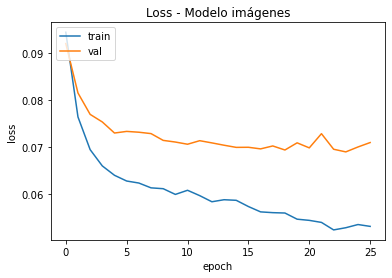

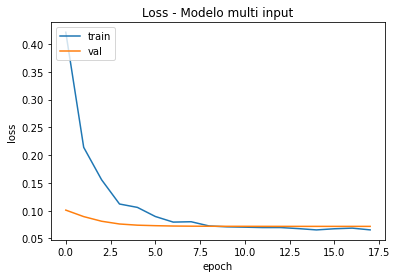

El error absoluto promedio del modelo que solo usa imágenes es 0.0709.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 52 finalizada


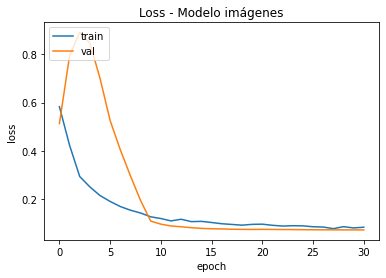

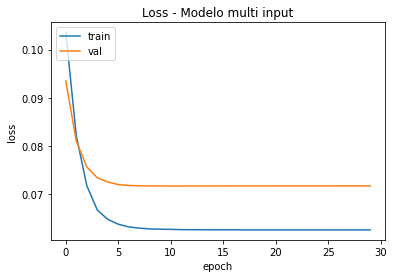

El error absoluto promedio del modelo que solo usa imágenes es 0.0722.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 53 finalizada


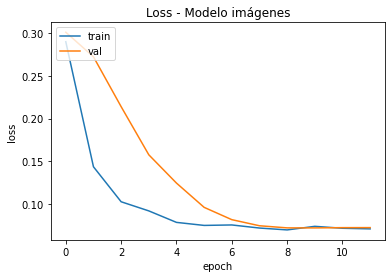

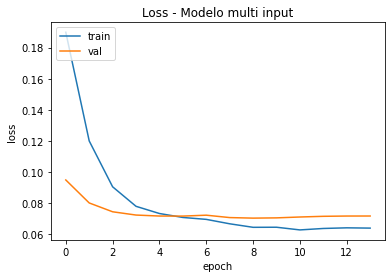

El error absoluto promedio del modelo que solo usa imágenes es 0.072.
    A su vez, el error absoluto promedio del modelo multi input es 0.0718.
Iteración 54 finalizada


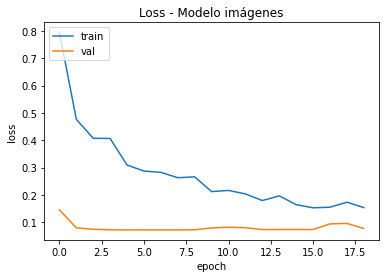

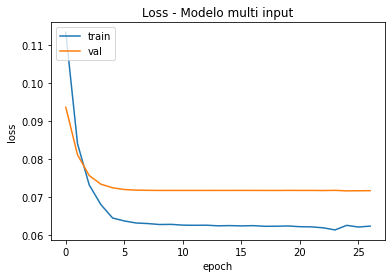

El error absoluto promedio del modelo que solo usa imágenes es 0.0769.
    A su vez, el error absoluto promedio del modelo multi input es 0.0716.
Iteración 55 finalizada


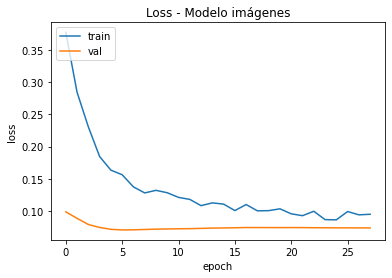

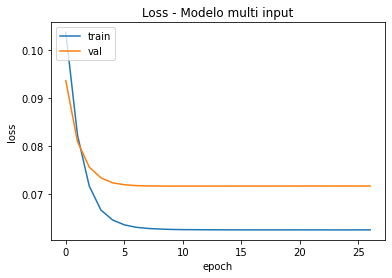

El error absoluto promedio del modelo que solo usa imágenes es 0.0736.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 56 finalizada


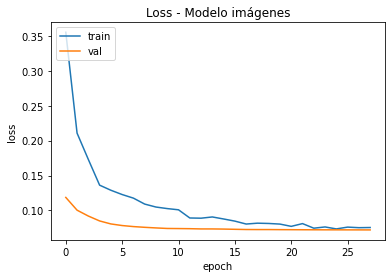

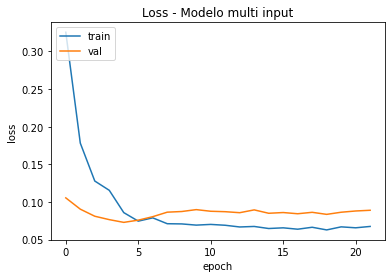

El error absoluto promedio del modelo que solo usa imágenes es 0.072.
    A su vez, el error absoluto promedio del modelo multi input es 0.0889.
Iteración 57 finalizada


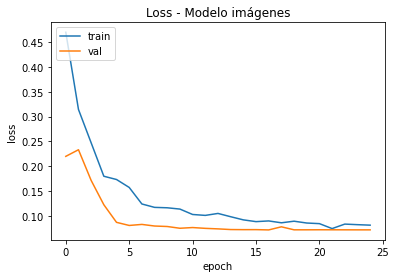

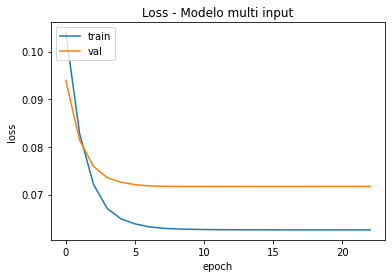

El error absoluto promedio del modelo que solo usa imágenes es 0.0718.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 58 finalizada


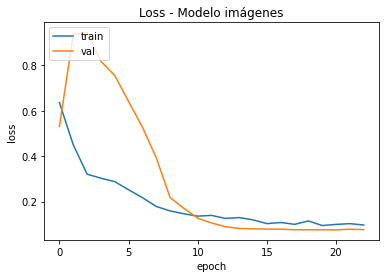

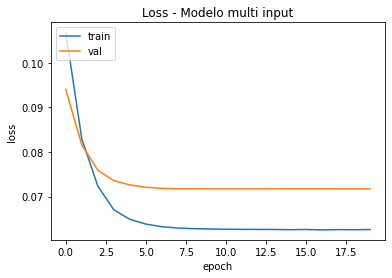

El error absoluto promedio del modelo que solo usa imágenes es 0.0766.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 59 finalizada


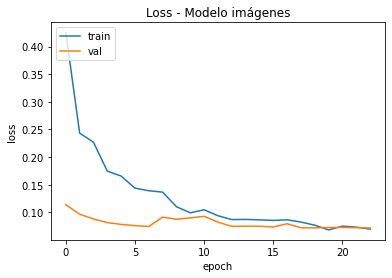

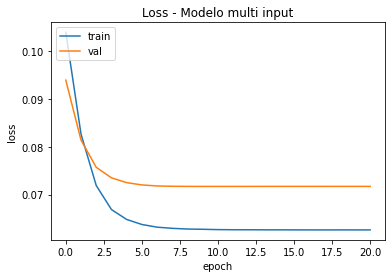

El error absoluto promedio del modelo que solo usa imágenes es 0.0719.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 60 finalizada


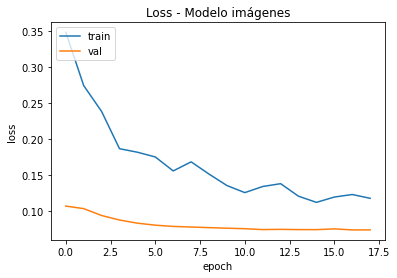

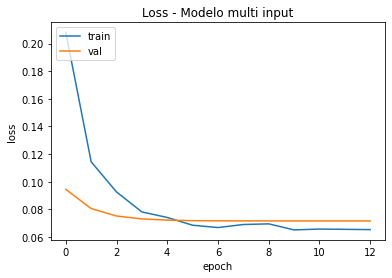

El error absoluto promedio del modelo que solo usa imágenes es 0.0736.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 61 finalizada


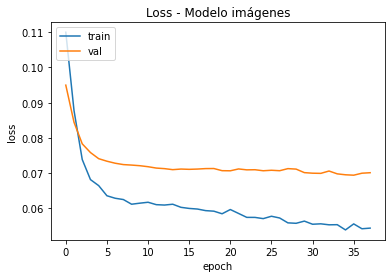

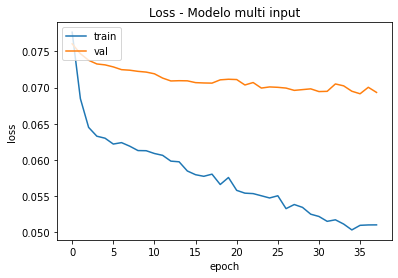

El error absoluto promedio del modelo que solo usa imágenes es 0.0701.
    A su vez, el error absoluto promedio del modelo multi input es 0.0693.
Iteración 62 finalizada


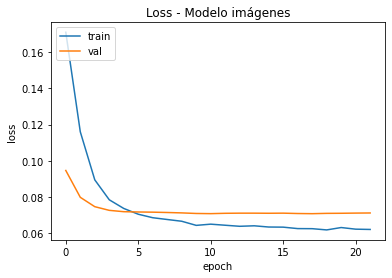

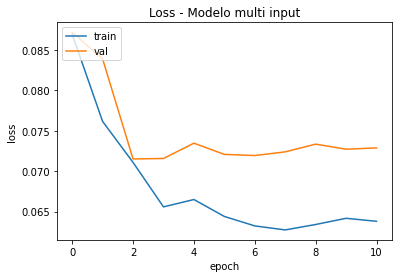

El error absoluto promedio del modelo que solo usa imágenes es 0.0712.
    A su vez, el error absoluto promedio del modelo multi input es 0.0729.
Iteración 63 finalizada


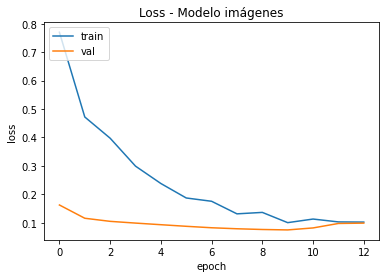

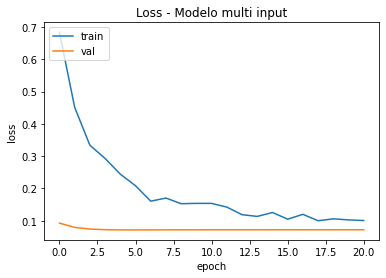

El error absoluto promedio del modelo que solo usa imágenes es 0.0988.
    A su vez, el error absoluto promedio del modelo multi input es 0.0722.
Iteración 64 finalizada


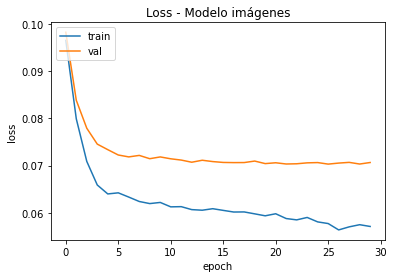

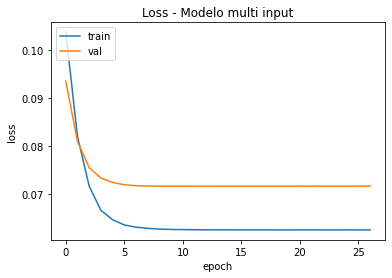

El error absoluto promedio del modelo que solo usa imágenes es 0.0706.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 65 finalizada


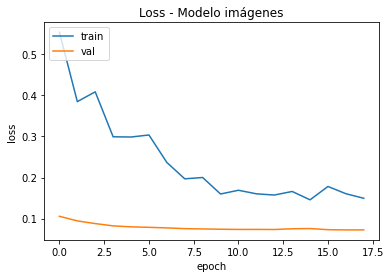

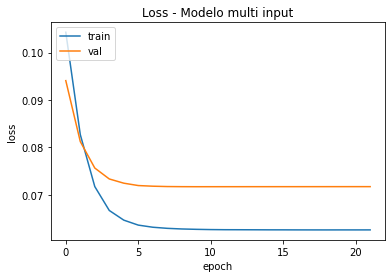

El error absoluto promedio del modelo que solo usa imágenes es 0.0725.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 66 finalizada


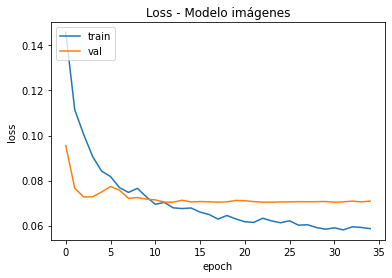

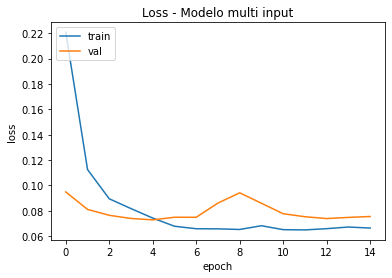

El error absoluto promedio del modelo que solo usa imágenes es 0.0709.
    A su vez, el error absoluto promedio del modelo multi input es 0.0755.
Iteración 67 finalizada


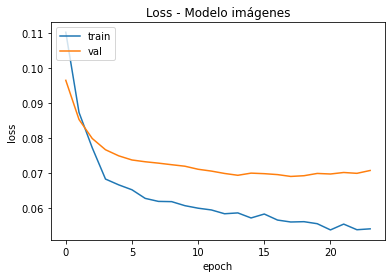

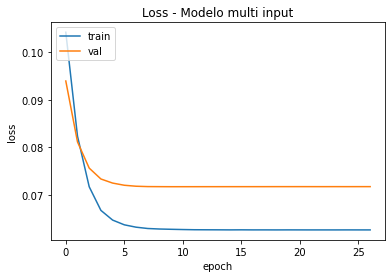

El error absoluto promedio del modelo que solo usa imágenes es 0.0707.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 68 finalizada


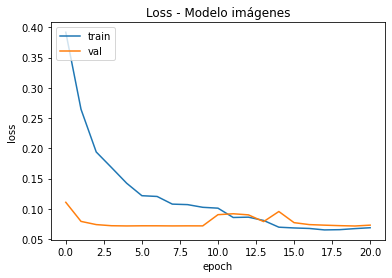

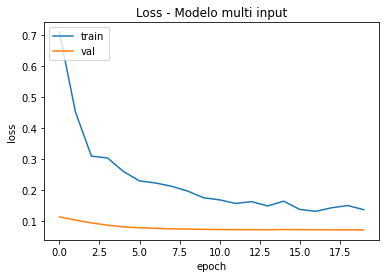

El error absoluto promedio del modelo que solo usa imágenes es 0.0731.
    A su vez, el error absoluto promedio del modelo multi input es 0.0725.
Iteración 69 finalizada


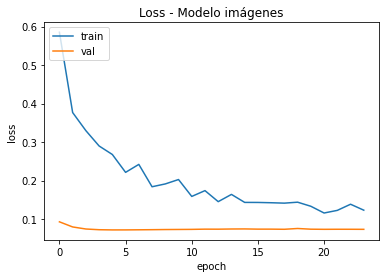

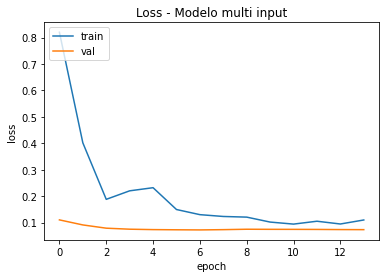

El error absoluto promedio del modelo que solo usa imágenes es 0.0732.
    A su vez, el error absoluto promedio del modelo multi input es 0.0734.
Iteración 70 finalizada


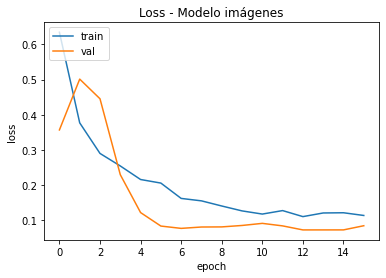

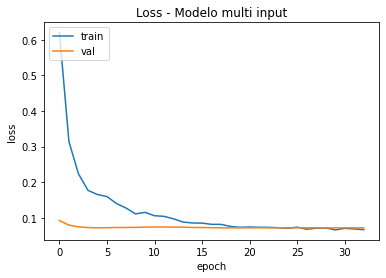

El error absoluto promedio del modelo que solo usa imágenes es 0.0843.
    A su vez, el error absoluto promedio del modelo multi input es 0.0718.
Iteración 71 finalizada


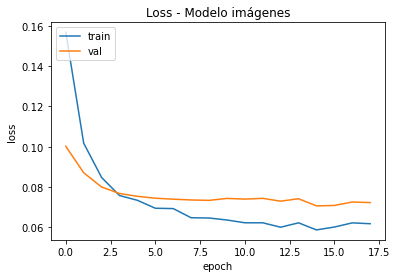

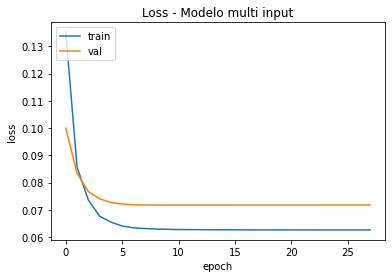

El error absoluto promedio del modelo que solo usa imágenes es 0.0723.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 72 finalizada


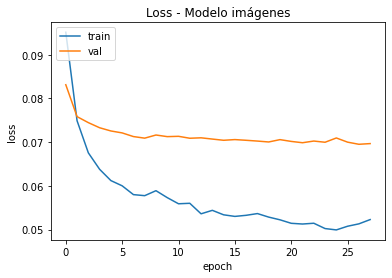

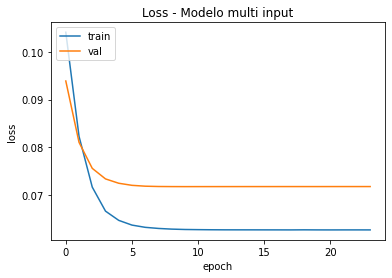

El error absoluto promedio del modelo que solo usa imágenes es 0.0697.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 73 finalizada


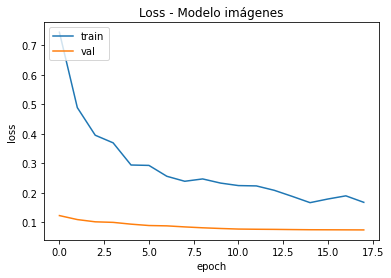

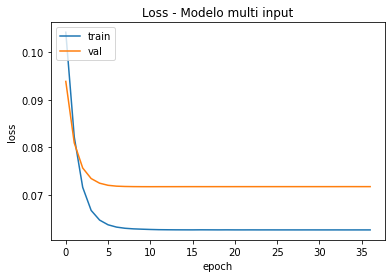

El error absoluto promedio del modelo que solo usa imágenes es 0.074.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 74 finalizada


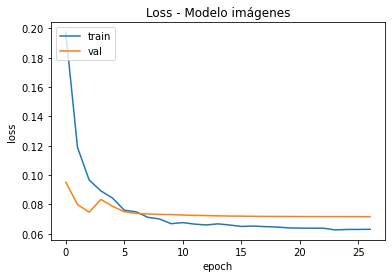

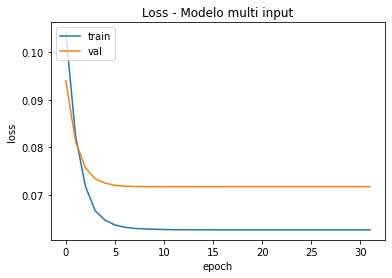

El error absoluto promedio del modelo que solo usa imágenes es 0.0716.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 75 finalizada


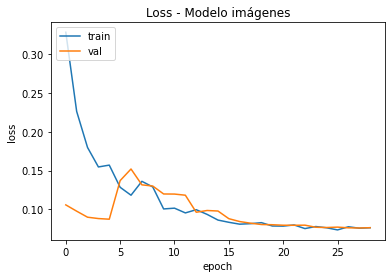

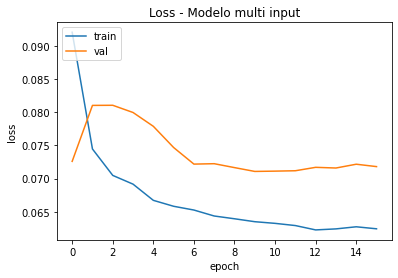

El error absoluto promedio del modelo que solo usa imágenes es 0.0764.
    A su vez, el error absoluto promedio del modelo multi input es 0.0718.
Iteración 76 finalizada


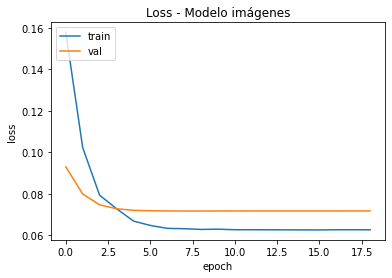

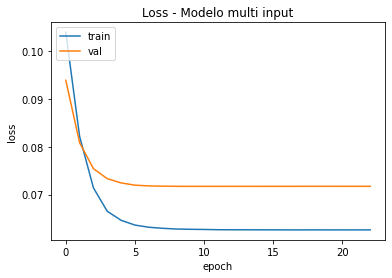

El error absoluto promedio del modelo que solo usa imágenes es 0.0717.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 77 finalizada


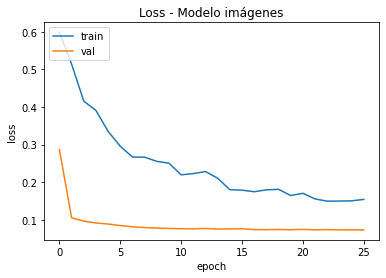

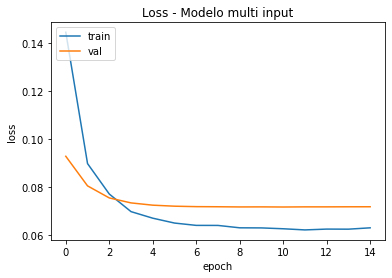

El error absoluto promedio del modelo que solo usa imágenes es 0.0732.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 78 finalizada


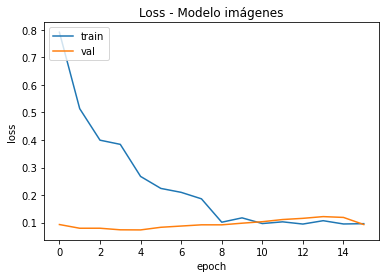

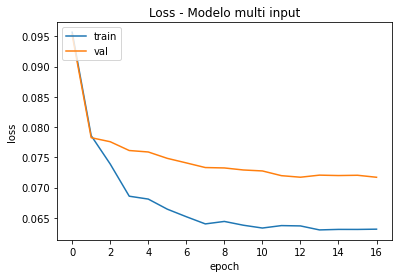

El error absoluto promedio del modelo que solo usa imágenes es 0.093.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 79 finalizada


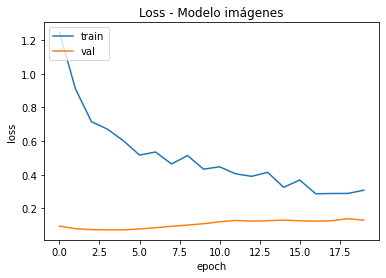

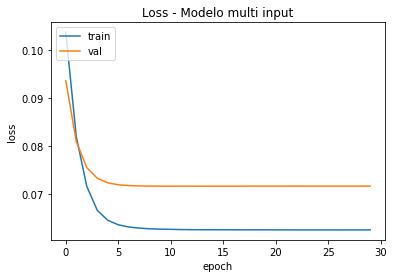

El error absoluto promedio del modelo que solo usa imágenes es 0.1307.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 80 finalizada


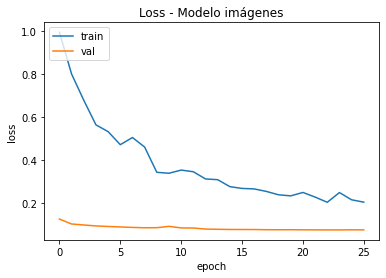

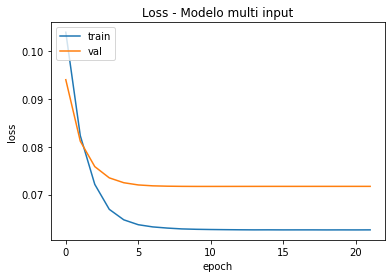

El error absoluto promedio del modelo que solo usa imágenes es 0.0741.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 81 finalizada


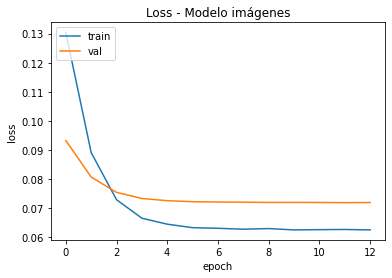

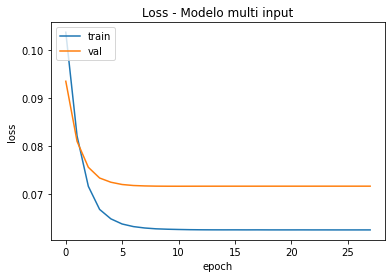

El error absoluto promedio del modelo que solo usa imágenes es 0.072.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 82 finalizada


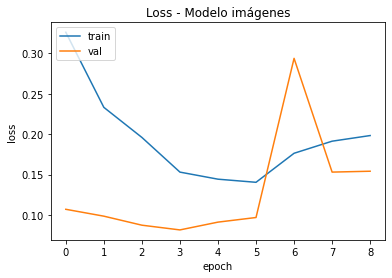

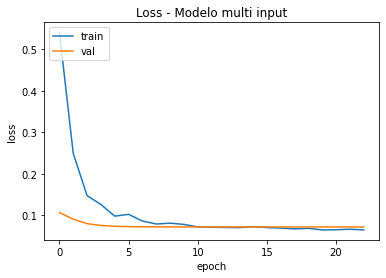

El error absoluto promedio del modelo que solo usa imágenes es 0.1542.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 83 finalizada


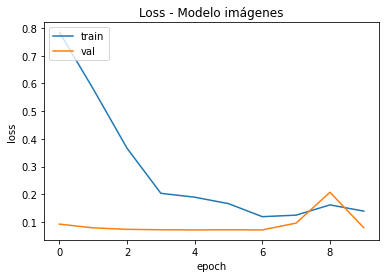

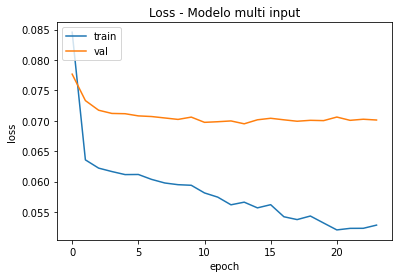

El error absoluto promedio del modelo que solo usa imágenes es 0.0796.
    A su vez, el error absoluto promedio del modelo multi input es 0.0701.
Iteración 84 finalizada


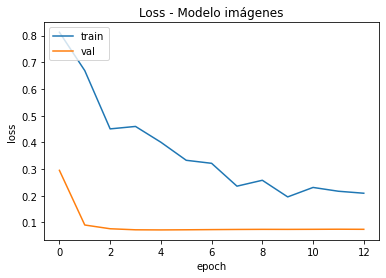

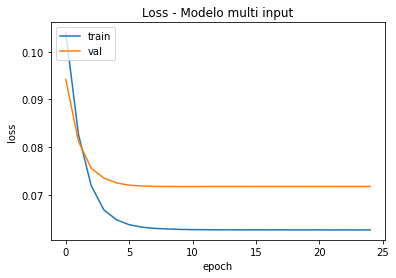

El error absoluto promedio del modelo que solo usa imágenes es 0.0744.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 85 finalizada


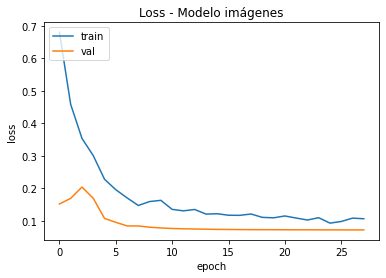

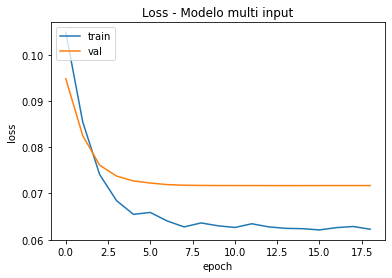

El error absoluto promedio del modelo que solo usa imágenes es 0.0722.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 86 finalizada


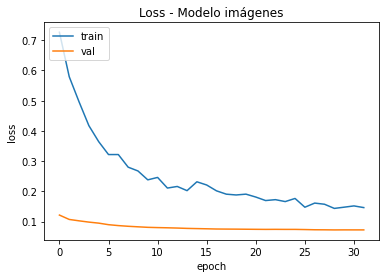

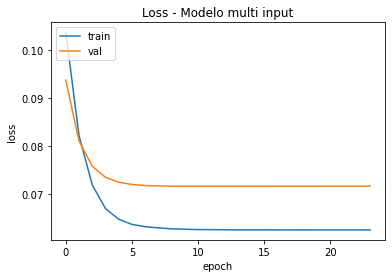

El error absoluto promedio del modelo que solo usa imágenes es 0.0724.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 87 finalizada


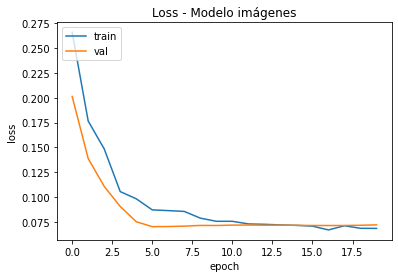

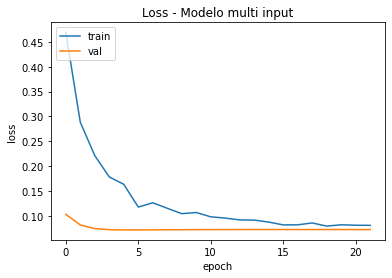

El error absoluto promedio del modelo que solo usa imágenes es 0.0723.
    A su vez, el error absoluto promedio del modelo multi input es 0.0724.
Iteración 88 finalizada


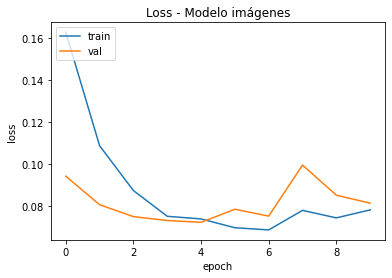

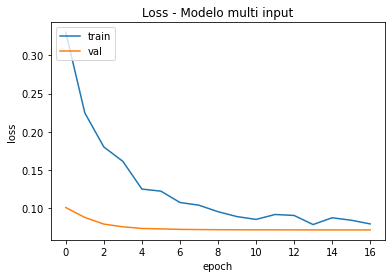

El error absoluto promedio del modelo que solo usa imágenes es 0.0812.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 89 finalizada


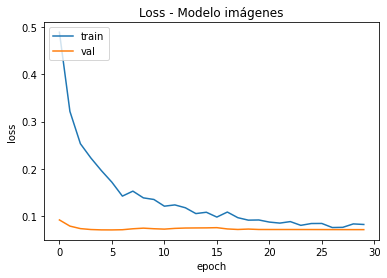

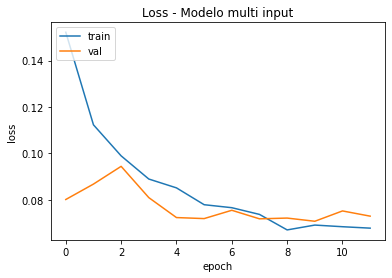

El error absoluto promedio del modelo que solo usa imágenes es 0.0723.
    A su vez, el error absoluto promedio del modelo multi input es 0.073.
Iteración 90 finalizada


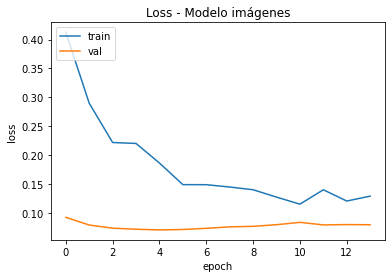

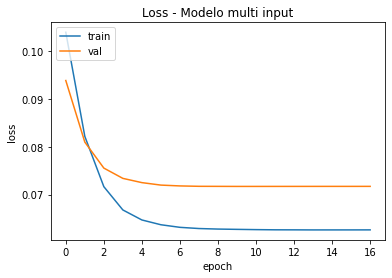

El error absoluto promedio del modelo que solo usa imágenes es 0.0798.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 91 finalizada


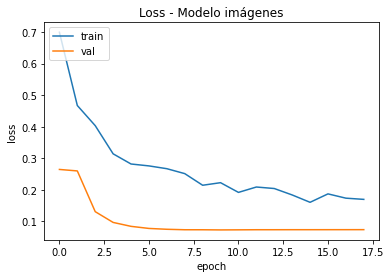

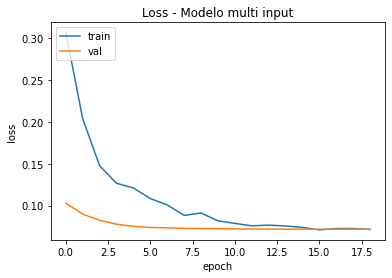

El error absoluto promedio del modelo que solo usa imágenes es 0.0742.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 92 finalizada


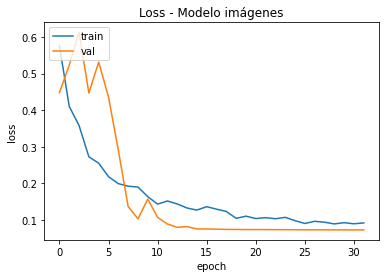

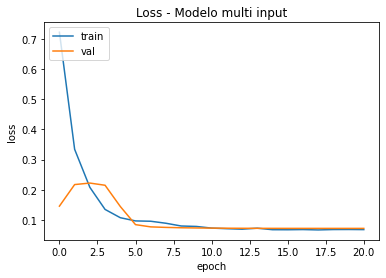

El error absoluto promedio del modelo que solo usa imágenes es 0.0724.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 93 finalizada


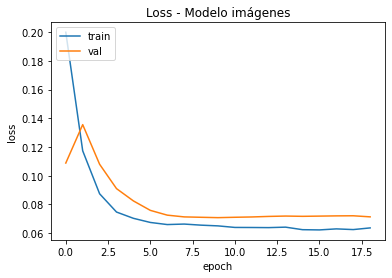

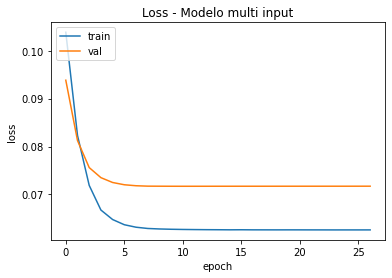

El error absoluto promedio del modelo que solo usa imágenes es 0.0713.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 94 finalizada


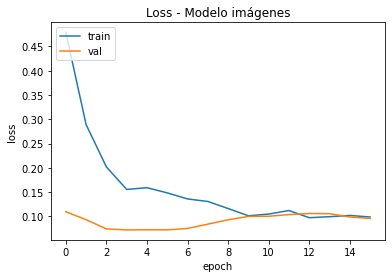

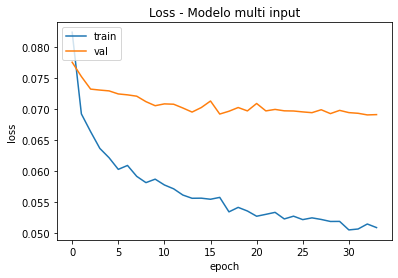

El error absoluto promedio del modelo que solo usa imágenes es 0.0958.
    A su vez, el error absoluto promedio del modelo multi input es 0.0691.
Iteración 95 finalizada


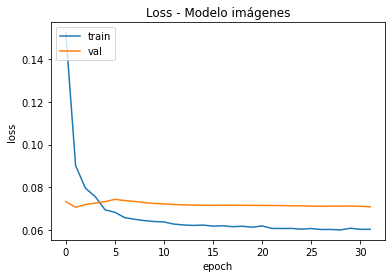

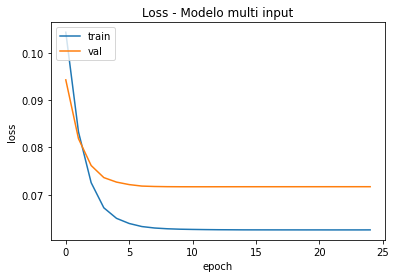

El error absoluto promedio del modelo que solo usa imágenes es 0.0708.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 96 finalizada


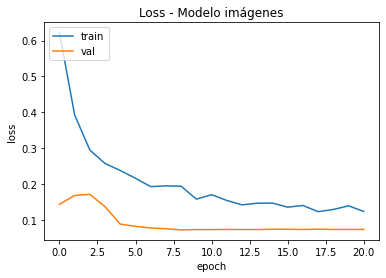

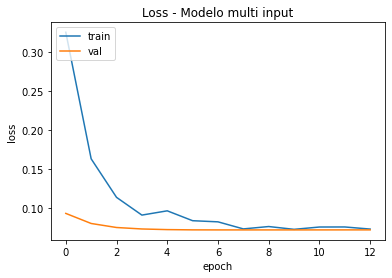

El error absoluto promedio del modelo que solo usa imágenes es 0.0736.
    A su vez, el error absoluto promedio del modelo multi input es 0.0718.
Iteración 97 finalizada


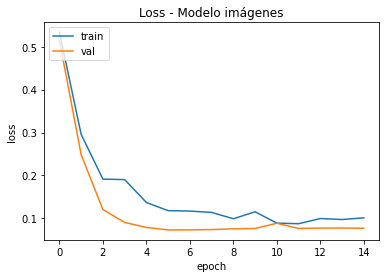

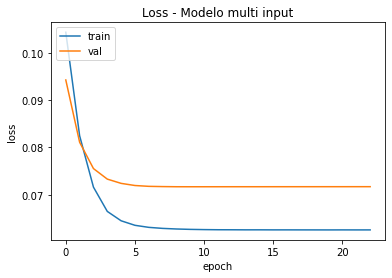

El error absoluto promedio del modelo que solo usa imágenes es 0.0769.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 98 finalizada


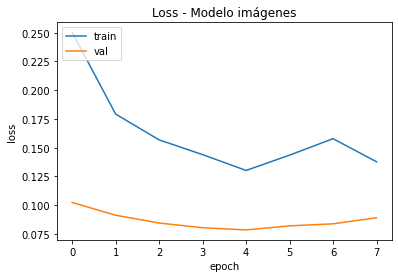

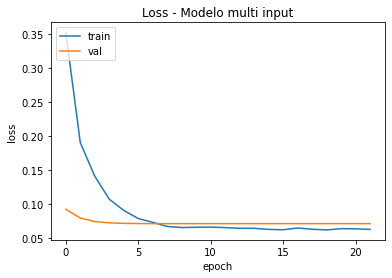

El error absoluto promedio del modelo que solo usa imágenes es 0.0891.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 99 finalizada


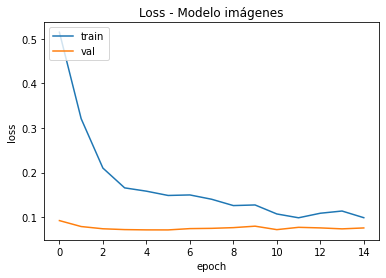

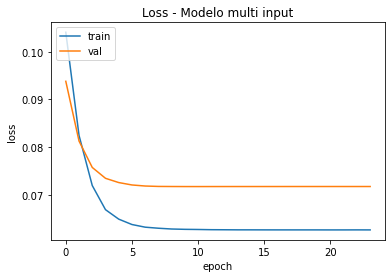

El error absoluto promedio del modelo que solo usa imágenes es 0.0761.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 100 finalizada


In [17]:
resultados_modelo_solo_imagenes = []
resultados_modelo_multi_input = []

for i in range(100): #Voy a correr 10 veces el experimento
    
    cnn1 = create_cnn(64, 64, 3)
    cnn2 = create_cnn(64, 64, 3)
    mlp = create_mlp(X_train_feat.shape[1])

    opt = Adam(lr=1e-3,decay = 1e-2) # Hiperparametros
    callback = EarlyStopping(monitor='loss', patience=3) # No quiero gastar recursos innecesarios, con callback

    cnn1.compile(loss="mae", 
                  optimizer=opt)

    #print("[INFO] Entrenando modelo con imágenes...")
    history_imagenes = cnn1.fit(
        x=imagenes_train, 
        y=y_train.values,
        validation_data=(imagenes_val, y_val.values),
        epochs=500, 
        batch_size=16,
        verbose=0,
        callbacks = [callback])

    # Listar la historia
    #print(history_imagenes.history.keys())
    # Generar gráficos
    plt.plot(history_imagenes.history['loss'])
    plt.plot(history_imagenes.history['val_loss'])
    plt.title('Loss - Modelo imágenes')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    y_pred_img = cnn1.predict(imagenes_val)

    error_promedio_imagenes = mean_absolute_error(y_val.values.flatten(),y_pred_img)
    
    resultados_modelo_solo_imagenes.append(error_promedio_imagenes)

    #Y ahora entreno el modelo que utiliza como insumos datos tabulares y las fotos

    combinedInput = concatenate([mlp.output, cnn2.output])
    x = Dense(1, activation="relu")(combinedInput)
    x = Dense(1, activation="linear")(x)

    model = Model(inputs=[mlp.input, cnn2.input], outputs=x)

    opt = Adam(lr=1e-3,decay = 1e-2) # Hiperparametros
    callback = EarlyStopping(monitor='loss', patience=3) # No quiero gastar recursos innecesarios, con callback

    model.compile(loss="mae", 
                  optimizer=opt)

    # Entrenamos el modelo
    #print("[INFO] Entrenando modelo multi input...")
    history = model.fit(
        x=[X_train_feat.values, imagenes_train], 
        y=y_train.values,
        validation_data=([X_val_feat.values, imagenes_val], y_val.values),
        epochs=100, 
        batch_size=16,
        verbose=0,
        callbacks = [callback])


    # Listar la historia
    #print(history.history.keys())
    # Generar gráficos
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss - Modelo multi input')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
    y_pred_mi = model.predict([X_val_feat.values, imagenes_val])

    error_promedio_mi = mean_absolute_error(y_val.values.flatten(),y_pred_mi)
    
    resultados_modelo_multi_input.append(error_promedio_mi)

    print(f"El error absoluto promedio del modelo que solo usa imágenes es {round(error_promedio_imagenes,4)}.\n\
    A su vez, el error absoluto promedio del modelo multi input es {round(error_promedio_mi,4)}." )
    print(f"Iteración {i+1} finalizada")
    
    del cnn1
    del cnn2
    del mlp


In [18]:
resultados_modelo_multi_input

[0.07172491574042898,
 0.07172766889092956,
 0.07172226756912876,
 0.07070873205792168,
 0.0717207941163411,
 0.07055654162536432,
 0.07224434448907606,
 0.07170958834864269,
 0.06843734526258213,
 0.07171955079510475,
 0.07180488191641882,
 0.0717435722015866,
 0.07305037906711216,
 0.0717273973002634,
 0.07194666517459782,
 0.07202022963710333,
 0.0717127697156423,
 0.07108892734798432,
 0.09421099512683037,
 0.07172047049353703,
 0.07123958324545769,
 0.0717197474780664,
 0.07186947655376014,
 0.07171180682857478,
 0.07221347580677351,
 0.07291572656007177,
 0.07172351815371926,
 0.07172084911461031,
 0.07160260430351302,
 0.07182671353962039,
 0.07173171894616233,
 0.07181417070659034,
 0.07172440925552476,
 0.0803306664150472,
 0.07174424219736542,
 0.0717383916366805,
 0.07172031560802337,
 0.0730188870096543,
 0.0717216225219746,
 0.0691712684117568,
 0.07269183406829934,
 0.07167395562406235,
 0.07224572260649349,
 0.0716020432145444,
 0.07171858463101839,
 0.06971014563028462,

In [19]:
resultados_modelo_solo_imagenes

[0.07256439277152293,
 0.1108902008468153,
 0.07355792558502859,
 0.07310218619852163,
 0.1300703568589203,
 0.06920659355812385,
 0.07345059974463954,
 0.07218377929264166,
 0.07186105766622952,
 0.0733647620500203,
 0.07931302052310484,
 0.07212817597763369,
 0.08132195303825537,
 0.07500782359387864,
 0.07616619965614592,
 0.07135159202818046,
 0.0748036759713108,
 0.07133867630231658,
 0.07304884684280753,
 0.07202845639589774,
 0.07371938601019498,
 0.07448740269354631,
 0.07122798504830868,
 0.0694567532156574,
 0.07305497936375861,
 0.07526550892966931,
 0.07170963704019638,
 0.0833844778957908,
 0.1549366579478424,
 0.07180888046680813,
 0.07171872081279237,
 0.07352072136453573,
 0.07396802400742188,
 0.07239223744865357,
 0.07296669535824848,
 0.07272933480019332,
 0.10317742101475663,
 0.07373513444028482,
 0.07471483999328782,
 0.07364615207980037,
 0.07278590814899326,
 0.07484442393659463,
 0.080105294176699,
 0.07358489585321776,
 0.07518850745687572,
 0.0725667896487258

In [20]:
imagenes_media = np.mean(resultados_modelo_solo_imagenes)
multi_input_media = np.mean(resultados_modelo_multi_input)

print("Promedio error solo imágenes:",imagenes_media)
print("Promedio error multi input:",multi_input_media)


imagenes_std = np.std(resultados_modelo_solo_imagenes)
multi_input_std = np.std(resultados_modelo_multi_input)

print("Desviación Estándar solo imágenes:",imagenes_std )
print("Desviación Estándar solo multi_input:",multi_input_std)

ttest,pval = ttest_ind(resultados_modelo_solo_imagenes,resultados_modelo_multi_input)

print("p-value",pval)
if pval <0.05:
  print("No aceptamos hipótesis nula, las medias debieran ser distintas")
else:
  print("Aceptamos la hipótesis nula, las medias deben ser equivalentes")

Promedio error solo imágenes: 0.07818387507244229
Promedio error multi input: 0.0721989466730435
Desviación Estándar solo imágenes: 0.015265998302153397
Desviación Estándar solo multi_input: 0.0030314027433050975
p-value 0.00017449299667085587
No aceptamos hipótesis nula, las medias debieran ser distintas


In [21]:
compara = pd.DataFrame(zip(resultados_modelo_multi_input,resultados_modelo_solo_imagenes),
      columns=['error_solo_imagen','error_multi_input'])

In [22]:
import seaborn as sns

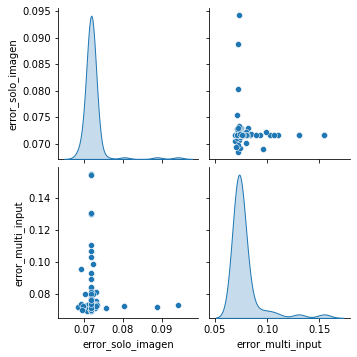

In [23]:
sns.pairplot(compara, diag_kind='kde')

In [24]:
compara.to_csv('resultados.csv',index=False)